# Определение стоимости автомобилей

## Описание данных
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Примечания
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные.

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


- Price — цена (евро)

## Подготовка данных

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Бросается в глаза, что колонки названы не в стиле snake_case.  
Для удобства сразу исправим это с помощью регекса.

In [4]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower() for column in data.columns]

Затем следует сразу избавиться от неинформативных признаков, которые точно не пригодятся.  
- Даты (date_crawled, date_created, last_seen)
- Количество фотографий (number_of_pictures)
- Почтовый индекс (postal_code)
- Месяц регистрации (registration_month)

In [5]:
data.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', \
           'postal_code', 'registration_month'], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Подберём более подходящие типы данных для уменьшения затрат памяти.

In [7]:
data['price'] = pd.to_numeric(data['price'], downcast='integer')
data['registration_year'] = pd.to_numeric(data['registration_year'], downcast='integer')
data['power'] = pd.to_numeric(data['power'], downcast='integer')
data['kilometer'] = pd.to_numeric(data['kilometer'], downcast='integer')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int16 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int16 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int16 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int32 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 19.6+ MB


Видим, что память удалось сэкономить.

Проверим данные на наличие аномалий и избавимся от них.

In [9]:
data.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


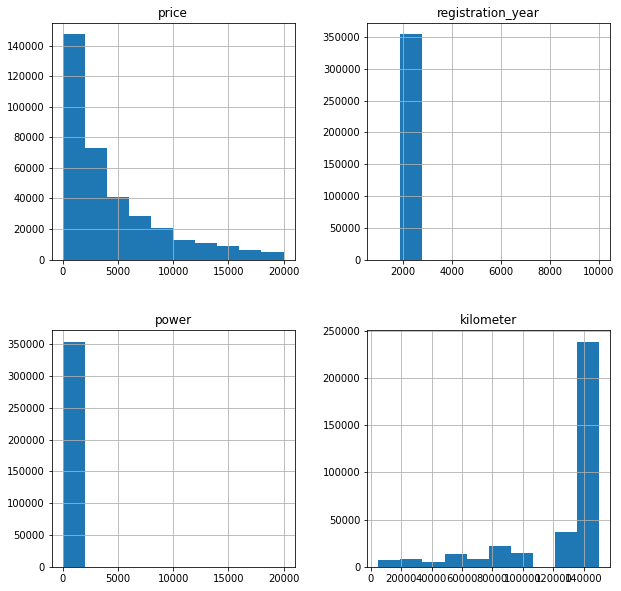

In [10]:
data.hist(figsize=(10,10))
plt.show()

**Цена**

In [11]:
data['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

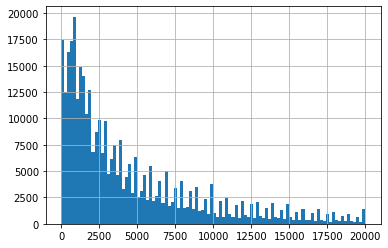

In [12]:
data['price'].hist(bins=100)
plt.show()

In [13]:
data['price'].quantile(.05)

200.0

Видим огромное количество нулевых значений, что нереалистично мало даже для поддержанных автомобилей.
Возьмём в рассмотрение автомобили ценой от 200 евро, начиная отбор в уже новый, фильтрованный набор.

In [14]:
filtered_data = data.query('price > 200')

**Год регистрации**

In [15]:
filtered_data['registration_year'].value_counts()

2000    21829
1999    21339
2005    21272
2006    19635
2003    19434
        ...  
1946        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 134, dtype: int64

Видим наличие огромных, аномальных значений года регистрации. Обязательно отсекаем эти данные.

In [16]:
filtered_data = filtered_data.query('2016 > registration_year > 1899')

**Мощность**

In [17]:
filtered_data['power'].value_counts()

0       27320
75      20629
150     13445
60      13427
140     12123
        ...  
421         1
1700        1
1793        1
572         1
1653        1
Name: power, Length: 664, dtype: int64

In [18]:
filtered_data = filtered_data.query('0 < power < 600')

**Пробег**

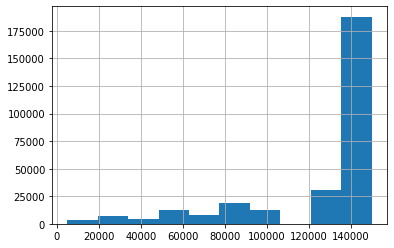

In [19]:
filtered_data['kilometer'].hist()
plt.show()

В результате некоторых манипуляций мы получили более реалистичную картину.

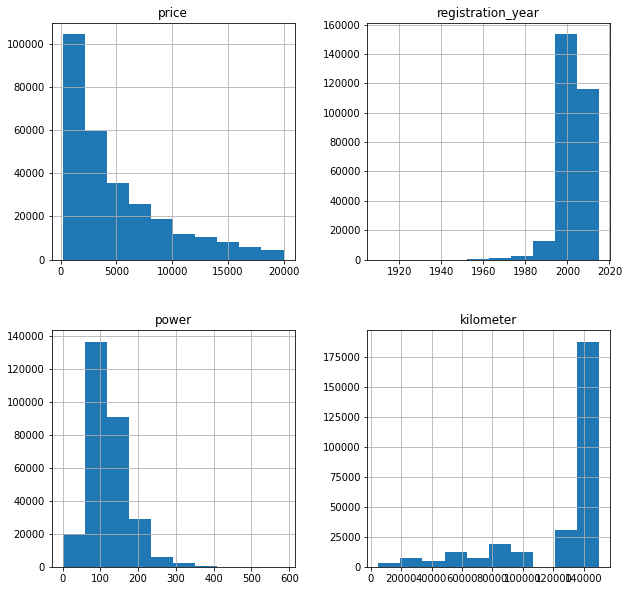

In [20]:
filtered_data.hist(figsize=(10,10))
plt.show()

In [21]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285350 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              285350 non-null  int16 
 1   vehicle_type       281054 non-null  object
 2   registration_year  285350 non-null  int16 
 3   gearbox            280755 non-null  object
 4   power              285350 non-null  int16 
 5   model              275379 non-null  object
 6   kilometer          285350 non-null  int32 
 7   fuel_type          273165 non-null  object
 8   brand              285350 non-null  object
 9   repaired           246812 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 18.0+ MB


Видим, что в нескольких колонках есть пропущенные значения.  
Попробуем это исправить.

Заполнение будет таким:
- gearbox - заполним значением manual
- model - нет возможности восстановить такие данные, заполняем заглушкой
- repaired - заполним значением no

In [22]:
filtered_data.fillna({'gearbox':'manual', 
                      'model':'unknown',
                      'repaired':'no'},
                       inplace=True)

In [23]:
filtered_data.isna().sum()

price                    0
vehicle_type          4296
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type            12185
brand                    0
repaired                 0
dtype: int64

Остались пропуски только в колонках типа кузова и типа топлива.  
Такие данные трудно заполнить достоверно, поэтому будет проще просто удалить.

In [24]:
filtered_data.dropna(inplace=True)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270700 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              270700 non-null  int16 
 1   vehicle_type       270700 non-null  object
 2   registration_year  270700 non-null  int16 
 3   gearbox            270700 non-null  object
 4   power              270700 non-null  int16 
 5   model              270700 non-null  object
 6   kilometer          270700 non-null  int32 
 7   fuel_type          270700 non-null  object
 8   brand              270700 non-null  object
 9   repaired           270700 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 17.0+ MB


Напоследок проверим наличие явных дубликатов и тоже избавимся от них.

In [25]:
filtered_data.duplicated().sum()

44298

In [26]:
filtered_data.drop_duplicates(inplace=True)

In [27]:
filtered_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Теперь данныые подготовлены к работе, приступим к обучению.

## Обучение моделей

В рамках эксперимента будем исследовать данные модели:
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

In [28]:
models = ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
rmse = []
training_time = []

In [29]:
target = filtered_data['price']
features = filtered_data.drop(['price'], axis=1)

cat_features = features.select_dtypes(include='object').columns.values
num_features = features.select_dtypes(exclude='object').columns.values

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.3, random_state=42)

### RandomForestRegressor

In [30]:
for feature in cat_features:
    features_train[feature] = features_train[feature].astype('category')
    features_test[feature] = features_test[feature].astype('category')

In [31]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='ignore'), cat_features)])

forest = Pipeline(steps=[
    ('enc', preprocessor),
    ('alg', RandomForestRegressor(random_state=42))
])

params = {
    'alg__n_estimators': [20, 40],
    'alg__max_depth': [8, 10, 15, 20],
    'alg__min_samples_split': [2, 4, 6],
}

In [32]:
%%time
RFR = GridSearchCV(forest, params, cv=3, verbose=10, n_jobs=-1, scoring='neg_root_mean_squared_error', error_score='raise')
RFR.fit(features_train, target_train)

rmse.append(abs(RFR.best_score_))
training_time.append(RFR.refit_time_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20
[CV 1/3; 1/24] END alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20; total time=   2.3s
[CV 2/3; 1/24] START alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20
[CV 2/3; 1/24] END alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20; total time=   2.2s
[CV 3/3; 1/24] START alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20
[CV 3/3; 1/24] END alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=20; total time=   2.3s
[CV 1/3; 2/24] START alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=40
[CV 1/3; 2/24] END alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=40; total time=   4.4s
[CV 2/3; 2/24] START alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=40
[CV 2/3; 2/24] END alg__max_depth=8, alg__min_samples_split=2, alg__n_estimators=40; total ti

### CatBoostRegressor

In [33]:
params = {
    'depth': [10, 20],
    'iterations': [100, 200, 300],
}

In [34]:
%%time
CBR = GridSearchCV(CatBoostRegressor(cat_features=cat_features, random_state=42), \
                   params, cv=3, verbose=10, n_jobs=-1, scoring='neg_root_mean_squared_error')
CBR.fit(features_train, target_train)

rmse.append(abs(CBR.best_score_))
training_time.append(CBR.refit_time_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START depth=10, iterations=100....................................
Learning rate set to 0.5
0:	learn: 3178.9348982	total: 109ms	remaining: 10.8s
1:	learn: 2493.9623040	total: 165ms	remaining: 8.1s
2:	learn: 2162.3156130	total: 225ms	remaining: 7.29s
3:	learn: 1990.9528294	total: 277ms	remaining: 6.65s
4:	learn: 1905.8626119	total: 327ms	remaining: 6.21s
5:	learn: 1856.2290880	total: 392ms	remaining: 6.13s
6:	learn: 1823.1242256	total: 441ms	remaining: 5.86s
7:	learn: 1800.6890239	total: 492ms	remaining: 5.66s
8:	learn: 1777.5854532	total: 542ms	remaining: 5.48s
9:	learn: 1759.2368057	total: 594ms	remaining: 5.34s
10:	learn: 1750.9166729	total: 642ms	remaining: 5.2s
11:	learn: 1735.7378172	total: 689ms	remaining: 5.05s
12:	learn: 1716.8373856	total: 738ms	remaining: 4.94s
13:	learn: 1708.7147482	total: 788ms	remaining: 4.84s
14:	learn: 1705.4343292	total: 841ms	remaining: 4.76s
15:	learn: 1698.6241836	total: 891ms

### LGBMRegressor

In [35]:
params = {
    'max_depth': [10, 20],
    'n_estimators': [20, 40, 60],
}

In [36]:
%%time
LGBMR = GridSearchCV(LGBMRegressor(categorical_feature=cat_features, random_state=42), \
                     params, cv=3, verbose=10, n_jobs=-1, scoring='neg_root_mean_squared_error')
LGBMR.fit(features_train, target_train)

rmse.append(abs(LGBMR.best_score_))
training_time.append(LGBMR.refit_time_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 1/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   1.4s
[CV 2/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 2/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   1.1s
[CV 3/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 3/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   1.4s
[CV 1/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 1/3; 2/6] END .............max_depth=10, n_estimators=40; total time=   2.1s
[CV 2/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 2/3; 2/6] END .............max_depth=10, n_estimators=40; total time=   2.0s
[CV 3/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 3/3; 2/6] END .............max_depth=10, n_es

## Анализ моделей

Произведём замер показателей на тестовых выборках в соответствии с требованиями заказчика и сравним результаты

In [37]:
print('Показатели кросс-валидации')
pd.DataFrame(data={'RMSE':rmse,
                   'Training Time':training_time},
                    index=models)

Показатели кросс-валидации


,RMSE,Training Time
RandomForestRegressor,1709.737477,11.704935
CatBoostRegressor,1626.186917,77.668309
LGBMRegressor,1681.799917,17.585678


А теперь проверим модели на тестовой выборке

In [38]:
rmse = []
training_time = []
prediction_time = []

def get_results(model, X_train=features_train, X_test=features_test, y_train=target_train, y_test=target_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time.append(round(time.time() - start_time, 2))
    
    start_time = time.time()
    predictions = model.predict(X_test)
    prediction_time.append(round(time.time() - start_time, 2))
    
    rmse.append(mean_squared_error(y_test, predictions) ** 0.5)

In [39]:
get_results(RFR.best_estimator_)
get_results(CBR.best_estimator_)
get_results(LGBMR.best_estimator_)

Learning rate set to 0.242592
0:	learn: 3906.3860711	total: 330ms	remaining: 1m 38s
1:	learn: 3296.9013630	total: 614ms	remaining: 1m 31s
2:	learn: 2860.3971549	total: 911ms	remaining: 1m 30s
3:	learn: 2546.7084673	total: 1.16s	remaining: 1m 25s
4:	learn: 2332.5755943	total: 1.45s	remaining: 1m 25s
5:	learn: 2179.5506695	total: 1.67s	remaining: 1m 22s
6:	learn: 2078.5715047	total: 1.91s	remaining: 1m 20s
7:	learn: 1996.4145808	total: 2.15s	remaining: 1m 18s
8:	learn: 1934.9199386	total: 2.35s	remaining: 1m 15s
9:	learn: 1891.1166861	total: 2.56s	remaining: 1m 14s
10:	learn: 1859.1542671	total: 2.78s	remaining: 1m 12s
11:	learn: 1837.8263551	total: 2.99s	remaining: 1m 11s
12:	learn: 1816.5379341	total: 3.21s	remaining: 1m 10s
13:	learn: 1798.0077878	total: 3.45s	remaining: 1m 10s
14:	learn: 1779.6133843	total: 3.66s	remaining: 1m 9s
15:	learn: 1768.7359930	total: 3.97s	remaining: 1m 10s
16:	learn: 1761.2630738	total: 4.18s	remaining: 1m 9s
17:	learn: 1753.1812375	total: 4.45s	remaining:

In [40]:
print('Показатели на тестовой выборке')
pd.DataFrame(data={'RMSE':rmse,
                   'Training Time':training_time,
                   'Prediction Time':prediction_time,},
                    index=models)

Показатели на тестовой выборке


,RMSE,Training Time,Prediction Time
RandomForestRegressor,1656.381146,12.05,0.69
CatBoostRegressor,1586.971705,73.24,0.32
LGBMRegressor,1648.549300,3.08,0.50


Переобучения не выявлено.  
Результаты кросс-валидации и на тестовой выборке получились практически идентичными, что позволяет нам сделать выводы.

## Вывод

В результате работы мы построили несколько моделей для предсказания стоимости автомобилей.
1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.


Были использованы:
+ пайплайн OrdinalEncoder + RandomForestRegressor
+ CatBoostRegressor
+ LightGBMRegressor


Наивысшие показатели по качеству и скорости предсказаний продемонстрировал **CatBoostRegressor** с RMSE=1626, временем обучения в 77 секунд и временем предсказания в 0.36 секунды.  
LGBMRegressor выигрывает лишь по скорости обучения.